# Pipeline de Machine Learning pour la prédiction et classification des soudures

In [2]:
# useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("deep")

In [3]:
# === 1) Chargement du dataset nettoyé
DATA_PATH = Path.cwd().parents[0] / "cleaning" / "outputs" / "weld_quality_clean_from_hf.csv"
df = pd.read_csv(DATA_PATH)
print("[INFO] Shape:", df.shape)
df.head()

[INFO] Shape: (1652, 58)


,Carbon concentration / (weight%),Silicon concentration / (weight%),Manganese concentration / (weight%),Sulphur concentration / (weight%),Phosphorus concentration / (weight%),Nickel concentration / (weight%),Chromium concentration / (weight%),Molybdenum concentration / (weight%),Vanadium concentration / (weight%),Copper concentration / (weight%),...,Niobium concentration / (wt%),Tin concentration / (wt%),Arsenic concentration / (wt%),Antimony concentration / (wt%),Type of weld;_raw,AC or DC_raw,Electrode positive or negative_raw,type_weld_enc,acdc_enc,polarity_enc
0,0.037,0.30,0.65,0.008,0.012,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,MMA,DC,+,0,1.0,1
1,0.037,0.30,0.65,0.008,0.012,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,MMA,DC,+,0,1.0,1
2,0.037,0.30,0.65,0.008,0.012,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,MMA,DC,+,0,1.0,1
3,0.037,0.31,1.03,0.007,0.014,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,MMA,DC,+,0,1.0,1
4,0.037,0.31,1.03,0.007,0.014,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,MMA,DC,+,0,1.0,1


In [4]:
print(df.shape)
print(df.columns)
print(df.isna().sum().sort_values(ascending=False).head(10))

(1652, 58)
Index(['Carbon concentration / (weight%)', 'Silicon concentration / (weight%)',
       'Manganese concentration / (weight%)',
       'Sulphur concentration / (weight%)',
       'Phosphorus concentration / (weight%)',
       'Nickel concentration / (weight%)',
       'Chromium concentration / (weight%)',
       'Molybdenum concentration / (weight%)',
       'Vanadium concentration / (weight%)',
       'Copper concentration / (weight%)', 'Cobalt concentration / (weight%)',
       'Tungsten concentration / (weight%)',
       'Oxygen concentration / parts per million by weight',
       'Titanium concentration / parts per million by weight',
       'Nitrogen concentration / parts per million by weight',
       'Aluminium concentration / parts per million by weight',
       'Boron concentration / parts per million by weight',
       'Niobium concentration / parts per million by weight',
       'Tin concentration / parts per million by weight',
       'Arsenic concentration / parts

In [5]:
df.dtypes.value_counts()

float64    46
object     10
int64       2
Name: count, dtype: int64

In [6]:
# 🎯 Définition des cibles et features
target_cols = [
    'Yield strength / MPa',
    'Ultimate tensile strength / MPa',
    'Elongation / %',
    'Hardness / kgmm-2'
]
feature_cols = [c for c in df.columns if c not in target_cols + ['Weld ID']]

In [7]:
# Sécuriser les cibles en numérique
import numpy as np, pandas as pd
for c in target_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

X_all = df[feature_cols].copy()

In [8]:
# Lignes labellisées (toutes cibles présentes)
label_mask = df[target_cols].notna().all(axis=1)
X_labeled  = X_all.loc[label_mask].copy()
y_labeled  = df.loc[label_mask, target_cols].copy()
X_unlabeled = X_all.loc[~label_mask].copy()

print(f"[INFO] Lignes labellisées : {X_labeled.shape[0]} / {df.shape[0]}")
print(f"[INFO] Lignes non labellisées gardées pour inference : {X_unlabeled.shape[0]}")
assert np.isfinite(y_labeled.to_numpy()).all(), "y contient des valeurs non finies."

[INFO] Lignes labellisées : 54 / 1652
[INFO] Lignes non labellisées gardées pour inference : 1598


In [9]:
# 🔪 Drop des colonnes 100% NaN côté train (indispensable pour l'imputation médiane)
from sklearn.model_selection import train_test_split

# Split sur les données labellisées uniquement
X_train, X_test, y_train, y_test = train_test_split(
    X_labeled, y_labeled, test_size=0.2, random_state=42
)

# Colonnes 100% NaN dans X_train
all_nan_cols = X_train.columns[X_train.isna().all(axis=0)]
if len(all_nan_cols) > 0:
    print("[INFO] Colonnes 100% NaN en train — drop:", list(all_nan_cols))
    X_train = X_train.drop(columns=all_nan_cols)
    X_test = X_test.drop(columns=all_nan_cols, errors="ignore")
    X_unlabeled = X_unlabeled.drop(columns=all_nan_cols, errors="ignore")

[INFO] Colonnes 100% NaN en train — drop: ['Charpy temperature / °C', 'Charpy impact toughness / J', 'Primary ferrite in microstructure / %', 'Ferrite with second phase / %', 'Acicular ferrite / %', 'Martensite / %', 'Ferrite with carbide aggreagate / %']


In [10]:
# 🧼 Prétraitement + Modèles
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.multioutput import MultiOutputRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [11]:
# Sélecteur numérique (sur DataFrame)
num_selector = make_column_selector(dtype_include=np.number)

# Prétraitement des colonnes numériques
numeric_preproc = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
preprocess = ColumnTransformer(
    transformers=[("num", numeric_preproc, num_selector)],
    remainder="drop"
)

In [12]:
# PLS: n_components dynamique (<= min(n_features, n_targets, 10))
n_features = X_train.shape[1]
n_targets  = y_train.shape[1]
pls_components = max(1, min(10, n_features, n_targets))

In [13]:
# Modèles de régression multi-sorties
models = {
    "RandomForest": MultiOutputRegressor(
        RandomForestRegressor(
            n_estimators=500,
            max_depth=None,
            random_state=42,
            n_jobs=-1
        )
    ),
    "PLSRegression": PLSRegression(n_components=pls_components)
}

In [14]:
# XGBoost optionnel
try:
    from xgboost import XGBRegressor
    xgb_params = dict(
        n_estimators=600,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        tree_method="hist"  # "gpu_hist" si GPU dispo
    )
    models["XGBRegressor"] = MultiOutputRegressor(XGBRegressor(**xgb_params))
    print("[INFO] XGBoost activé.")
except Exception as e:
    print(f"[INFO] XGBoost non disponible ({e}). On continue sans XGB.")

[INFO] XGBoost activé.


In [15]:
# Pipelines complets
from sklearn.pipeline import Pipeline
pipelines = {name: Pipeline(steps=[("prep", preprocess), ("model", mdl)])
             for name, mdl in models.items()}

In [16]:
# 📏 Entraînement & Évaluation régression (R², MAE, RMSE)
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


def eval_regression(y_true: pd.DataFrame, y_pred: np.ndarray, label: str):
    scores = {}
    r2_per_target, mae_per_target, rmse_per_target = {}, {}, {}

    for i, col in enumerate(y_true.columns):
        r2 = r2_score(y_true[col], y_pred[:, i])
        mae = mean_absolute_error(y_true[col], y_pred[:, i])
        mse = mean_squared_error(y_true[col], y_pred[:, i])
        rmse = np.sqrt(mse)

        r2_per_target[col] = r2
        mae_per_target[col] = mae
        rmse_per_target[col] = rmse

    scores["R2_mean"] = float(np.mean(list(r2_per_target.values())))
    scores["MAE_mean"] = float(np.mean(list(mae_per_target.values())))
    scores["RMSE_mean"] = float(np.mean(list(rmse_per_target.values())))

    print(f"\n=== {label} — Évaluation Régression ===")
    print("R² par cible:")
    for k, v in r2_per_target.items():
        print(f"  {k:<30} : {v: .3f}")
    print("\nMAE par cible:")
    for k, v in mae_per_target.items():
        print(f"  {k:<30} : {v: .3f}")
    print("\nRMSE par cible:")
    for k, v in rmse_per_target.items():
        print(f"  {k:<30} : {v: .3f}")

    print("\n— Moyennes macro —")
    for k, v in scores.items():
        print(f"  {k:<10}: {v: .3f}")
    return scores


fitted = {}
reg_scores = {}
for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    fitted[name] = pipe
    y_pred = pipe.predict(X_test)
    reg_scores[name] = eval_regression(y_test, y_pred, f"Modèle {name}")

# Meilleur modèle au macro-R²
best_model_name = max(reg_scores, key=lambda n: reg_scores[n]["R2_mean"])
best_regressor = fitted[best_model_name]
print(f"\n🏆 Meilleur modèle (macro R²): {best_model_name} → {reg_scores[best_model_name]['R2_mean']:.3f}")


=== Modèle RandomForest — Évaluation Régression ===
R² par cible:
  Yield strength / MPa           :  0.366
  Ultimate tensile strength / MPa :  0.536
  Elongation / %                 :  0.663
  Hardness / kgmm-2              :  0.636

MAE par cible:
  Yield strength / MPa           :  52.081
  Ultimate tensile strength / MPa :  42.569
  Elongation / %                 :  1.938
  Hardness / kgmm-2              :  13.285

RMSE par cible:
  Yield strength / MPa           :  68.118
  Ultimate tensile strength / MPa :  56.316
  Elongation / %                 :  2.361
  Hardness / kgmm-2              :  18.435

— Moyennes macro —
  R2_mean   :  0.550
  MAE_mean  :  27.468
  RMSE_mean :  36.308

=== Modèle PLSRegression — Évaluation Régression ===
R² par cible:
  Yield strength / MPa           :  0.597
  Ultimate tensile strength / MPa :  0.657
  Elongation / %                 :  0.656
  Hardness / kgmm-2              :  0.626

MAE par cible:
  Yield strength / MPa           :  42.812
  Ulti

In [17]:
# 🧪 Classification "Bonne/Mauvaise" (label dérivé des propriétés)
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report

present_targets = [c for c in target_cols if c in y_train.columns]
assert len(present_targets) >= 2, "Besoin d'au moins 2 cibles pour un label robuste."

# Seuils (médianes du train) pour éviter la fuite d'info
thresholds = {c: y_train[c].median() for c in present_targets}
print("\nSeuils (médianes train) pour label binaire :")
for k, v in thresholds.items():
    print(f"  {k:<30} : {v:.2f}")


def make_label(df_targets: pd.DataFrame, thr: dict, need_at_least=3):
    scores = np.zeros(len(df_targets), dtype=int)
    for c in df_targets.columns:
        if c == 'Hardness / kgmm-2':
            hard_thr = np.quantile(y_train[c].dropna(), 0.90)  # pénalise duretés extrêmes
            good = (df_targets[c] <= hard_thr)
        else:
            good = (df_targets[c] >= thr[c])
        scores += good.astype(int)
    return (scores >= need_at_least).astype(int)  # 1=Bonne, 0=Mauvaise


y_train_bin = make_label(y_train[present_targets], thresholds, need_at_least=min(3, len(present_targets)))
y_test_bin = make_label(y_test[present_targets], thresholds, need_at_least=min(3, len(present_targets)))

print(f"\nRépartition label (train) — [0,1] :", np.bincount(y_train_bin))

# Classifieur (sur X, pas sur y)
clf_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=500, max_depth=None, random_state=42,
        class_weight="balanced", n_jobs=-1
    ))
])
clf_pipe.fit(X_train, y_train_bin)
y_pred_bin = clf_pipe.predict(X_test)
y_proba_bin = clf_pipe.predict_proba(X_test)[:, 1]

print("\n=== Évaluation Classification ===")
print(classification_report(y_test_bin, y_pred_bin, digits=3))
print("Accuracy :", accuracy_score(y_test_bin, y_pred_bin))
print("F1-score :", f1_score(y_test_bin, y_pred_bin))
try:
    print("ROC-AUC  :", roc_auc_score(y_test_bin, y_proba_bin))
except Exception:
    pass
print("\nMatrice de confusion :\n", confusion_matrix(y_test_bin, y_pred_bin))


Seuils (médianes train) pour label binaire :
  Yield strength / MPa           : 519.90
  Ultimate tensile strength / MPa : 600.40
  Elongation / %                 : 23.00
  Hardness / kgmm-2              : 216.00

Répartition label (train) — [0,1] : [26 17]

=== Évaluation Classification ===
              precision    recall  f1-score   support

           0      0.750     1.000     0.857         6
           1      1.000     0.600     0.750         5

    accuracy                          0.818        11
   macro avg      0.875     0.800     0.804        11
weighted avg      0.864     0.818     0.808        11

Accuracy : 0.8181818181818182
F1-score : 0.75
ROC-AUC  : 0.9

Matrice de confusion :
 [[6 0]
 [2 3]]


In [18]:
# 🧰 Fonctions utilitaires (inférence)
def predict_properties(X_new: pd.DataFrame, model=best_regressor):
    """
    X_new : DataFrame avec les mêmes features que X_train (mêmes colonnes restantes après drop all-NaN).
    Retourne un DataFrame des prédictions des propriétés mécaniques.
    """
    preds = model.predict(X_new)
    if preds.ndim == 1:
        preds = preds.reshape(-1, 1)
    return pd.DataFrame(preds, columns=y_train.columns[:preds.shape[1]])


def classify_weld(X_new: pd.DataFrame, regress_model=best_regressor, clf_model=clf_pipe,
                  thr=thresholds, need_at_least=min(3, len(present_targets))):
    """
    1) Prédit les propriétés mécaniques
    2) Applique la règle 'Bonne/Mauvaise' sur ces prédictions
    3) Retourne propriétés + label + proba RF
    """
    y_hat = predict_properties(X_new, regress_model)
    label_from_pred = make_label(y_hat[present_targets], thr, need_at_least=need_at_least)
    try:
        proba = clf_model.predict_proba(X_new)[:, 1]
    except Exception:
        proba = np.full(len(X_new), np.nan)
    out = y_hat.copy()
    out["GoodWeld_pred_rule"] = label_from_pred
    out["GoodWeld_proba_RF"] = proba
    return out

In [46]:
# ==========================================================
# 🔧 CLASSIFICATION COMBINÉE : PROBA + RÈGLE MÉDIANE
# ==========================================================
from datetime import datetime
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1️⃣ Prédiction complète sur toutes les soudures ---
X_full = pd.concat([X_unlabeled, X_labeled], axis=0)
pred_all = classify_weld(X_full)

# --- 2️⃣ Tri décroissant par probabilité ---
pred_all_sorted = pred_all.sort_values(by="GoodWeld_proba_RF", ascending=False)
pred_all_sorted.insert(0, "Rank", np.arange(1, len(pred_all_sorted) + 1))
pred_all_sorted["GoodWeld_proba_RF_pct"] = (pred_all_sorted["GoodWeld_proba_RF"] * 100).round(2)

In [47]:
# ==========================================================
# 2️⃣ CLASSIFICATION PAR PROBABILITÉ SEULE
# ==========================================================
p_good = 0.50
p_bad = 0.30

def base_prob_label(p):
    if p >= p_good:
        return "GOOD"
    elif p <= p_bad:
        return "BAD"
    else:
        return "UNCERTAIN"

pred_all_sorted["Base_Label"] = pred_all_sorted["GoodWeld_proba_RF"].apply(base_prob_label)

In [48]:
# ==========================================================
# 3️⃣ RAFFINEMENT DES INCERTAINS PAR LA RÈGLE MÉDIANE
# ==========================================================
def refine_uncertain(row, thresholds, need_at_least=3):
    """
    Pour les soudures incertaines : vérifie les 4 critères mécaniques
    Si au moins 3 atteignent la médiane → GOOD, sinon reste UNCERTAIN
    """
    if row["Base_Label"] != "UNCERTAIN":
        return row["Base_Label"]  # on garde le label déjà certain

    ok_count = 0
    for col, thr in thresholds.items():
        val = row[col]
        if col == "Hardness / kgmm-2":
            hard_thr = np.quantile(pred_all_sorted["Hardness / kgmm-2"].dropna(), 0.90)
            if val <= hard_thr:
                ok_count += 1
        else:
            if val >= thr:
                ok_count += 1

    if ok_count >= need_at_least:
        return "GOOD"
    elif ok_count <= 1:
        return "BAD"
    else:
        return "UNCERTAIN"

pred_all_sorted["Final_Label"] = pred_all_sorted.apply(
    refine_uncertain, axis=1, thresholds=thresholds, need_at_least=3
)

In [49]:
# ==========================================================
# 4️⃣ RÉSUMÉ ET EXPORTATION
# ==========================================================
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
OUT_DIR = Path.cwd() / "outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

final_csv = OUT_DIR / f"weld_predictions_final_{timestamp}.csv"
pred_all_sorted.to_csv(final_csv, index=False)
print(f"[✅] Fichier global sauvegardé : {final_csv}")

# Comptage des catégories
print("\n📊 Répartition finale :")
print(pred_all_sorted["Final_Label"].value_counts())


[✅] Fichier global sauvegardé : C:\Users\Guillaume PORET\PycharmProjects\pythonProject\Central\weld-quality\src\pre-processing\outputs\weld_predictions_final_20251020_201611.csv

📊 Répartition finale :
Final_Label
GOOD         846
UNCERTAIN    441
BAD          365
Name: count, dtype: int64


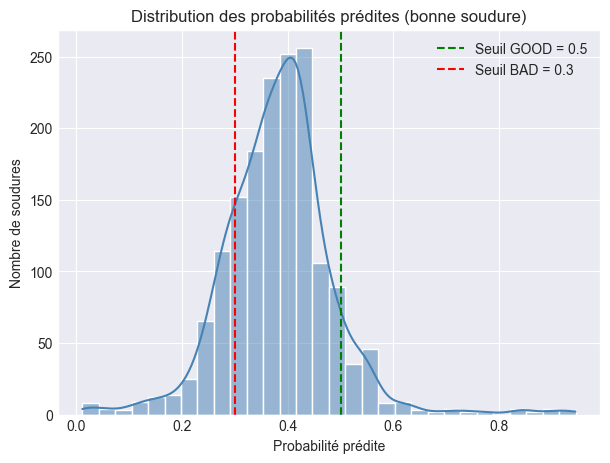

In [50]:
# ==========================================================
# 5️⃣ VISUALISATION : DISTRIBUTION DES PROBABILITÉS
# ==========================================================
plt.figure(figsize=(7,5))
sns.histplot(pred_all_sorted["GoodWeld_proba_RF"], bins=30, kde=True, color="steelblue")
plt.axvline(p_good, color="green", linestyle="--", label=f"Seuil GOOD = {p_good}")
plt.axvline(p_bad, color="red", linestyle="--", label=f"Seuil BAD = {p_bad}")
plt.title("Distribution des probabilités prédites (bonne soudure)")
plt.xlabel("Probabilité prédite")
plt.ylabel("Nombre de soudures")
plt.legend()
plt.show()

In [52]:
# ==========================================================
# 6️⃣ ANALYSE : INFLUENCE DES INDICATEURS
# ==========================================================
corrs = (
    pred_all_sorted[[
        "Yield strength / MPa",
        "Ultimate tensile strength / MPa",
        "Elongation / %",
        "Hardness / kgmm-2",
        "GoodWeld_proba_RF"
    ]]
    .corr()["GoodWeld_proba_RF"]
    .drop("GoodWeld_proba_RF")
    .sort_values(ascending=False)
)

print("\n🔥 Influence des indicateurs sur la probabilité d'une bonne soudure :")
display(corrs.to_frame("Correlation").style.background_gradient(cmap="coolwarm", axis=0))


🔥 Influence des indicateurs sur la probabilité d'une bonne soudure :


,Correlation
Ultimate tensile strength / MPa,0.212458
Yield strength / MPa,0.201521
Hardness / kgmm-2,0.197265
Elongation / %,-0.225308


In [54]:
# ==========================================================
# 7️⃣ SYNTHÈSE TABLEAU RÉSUMÉ
# ==========================================================
summary = (
    pred_all_sorted["Final_Label"]
    .value_counts(normalize=True)
    .rename_axis("Decision")
    .reset_index(name="Proportion")
)

print("\n📈 Répartition globale des soudures (proportions) :")
display(summary.style.format({"Proportion": "{:.2%}"}))


📈 Répartition globale des soudures (proportions) :


,Decision,Proportion
0,GOOD,51.21%
1,UNCERTAIN,26.69%
2,BAD,22.09%


# ⚙️ Règles de décision pour la classification des soudures (méthode finale)

Chaque soudure est évaluée à partir de **quatre propriétés mécaniques clés** prédites par les modèles de régression, puis classée selon une logique **hybride : probabiliste + physique**.

---

## 🔩 Critères mécaniques utilisés

| Critère mécanique | Condition de validation | Logique physique | Interprétation |
|--------------------|------------------------|------------------|----------------|
| **Yield strength / MPa** | ≥ médiane du jeu d’entraînement | Une limite d’élasticité élevée traduit une bonne résistance à la charge. | ✅ Plus la valeur est élevée, plus la soudure est robuste. |
| **Ultimate tensile strength / MPa** | ≥ médiane du jeu d’entraînement | Indique la résistance maximale avant rupture. | ✅ Haute valeur = bonne cohésion du métal fondu. |
| **Elongation / %** | ≥ médiane du jeu d’entraînement | Mesure la ductilité (capacité à se déformer sans casser). | ✅ Une grande élongation signifie une bonne ténacité. |
| **Hardness / kgmm-2** | ≤ 90e percentile du jeu d’entraînement | Une dureté excessive fragilise la soudure. | ⚠️ Trop dure → risque de fissuration. |

---

## 🧮 Étape 1 — Classification probabiliste initiale

Chaque soudure reçoit une **probabilité prédite** (`GoodWeld_proba_RF`) issue du modèle Random Forest Classifier.
Elle représente la confiance du modèle dans le fait qu’une soudure soit *bonne*.

| Probabilité | Catégorie initiale (`Base_Label`) | Interprétation |
|--------------|----------------------------------|----------------|
| ≥ **0.50** | 🟢 **GOOD** | Soudure jugée solide avec haute confiance. |
| ≤ **0.30** | 🔴 **BAD** | Soudure très probablement défaillante. |
| Entre **0.30 et 0.50** | 🟡 **UNCERTAIN** | Zone grise, nécessitant une validation mécanique. |

---

## ⚖️ Étape 2 — Raffinement des soudures incertaines

Les soudures classées *incertaines* sont réévaluées à l’aide de la **règle médiane** :
on compte combien de critères mécaniques dépassent leur seuil de validation.

| Nombre de critères validés | Décision finale | Interprétation |
|-----------------------------|-----------------|----------------|
| **≥ 3 sur 4** | 🟢 **GOOD** | Les performances mécaniques compensent l’incertitude statistique. |
| **≤ 1 sur 4** | 🔴 **BAD** | Trop de critères en dessous des seuils : soudure rejetée. |
| **2 sur 4** | 🟡 **UNCERTAIN** | Résultat équilibré : nécessite une expertise humaine. |

---

## 🧩 Étape 3 — Fusion finale des décisions

| Combinaison finale | `Final_Label` | Interprétation |
|--------------------|---------------|----------------|
| `Base_Label = GOOD` | 🟢 **GOOD** | Bonne soudure statistiquement. |
| `Base_Label = BAD` | 🔴 **BAD** | Mauvaise soudure confirmée. |
| `Base_Label = UNCERTAIN` + Raffinement ≥ 3 critères | 🟢 **GOOD** | Réhabilitée mécaniquement. |
| `Base_Label = UNCERTAIN` + Raffinement ≤ 1 critère | 🔴 **BAD** | Rejetée mécaniquement. |
| `Base_Label = UNCERTAIN` + Raffinement = 2 critères | 🟡 **UNCERTAIN** | Cas limite à examiner. |

---

## ✅ En résumé

Cette approche à deux étages combine :
1. **L’intelligence du modèle** (probabilité prédite de bonne soudure),
2. **La logique métier** (analyse physique via la règle des médianes).

🔹 Elle permet de :
- Identifier rapidement les soudures **sûres** (≥ 50 %)
- Écarter les **défaillantes** (≤ 30 %)
- Examiner finement les **zones grises** selon leurs propriétés mécaniques.